At the end of the experiment:

* Understand how to derive Eigen faces using PCA
* Use the PCA features for classification purpose.

### Description 

The dataset choosen for this experiment is a preprocessed excerpt of the “Labeled Faces in the Wild”, aka LFW. 

Labeled Faces in the Wild, a database of face photographs designed for studying the problem of unconstrained face recognition. The data set contains more than 13,000 images of faces collected from the web. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. The only constraint on these faces is that they were detected by the Viola-Jones face detector. 

### Eigen Faces

Eigenfaces is the name given to a set of eigenvectors when they are used in the computer vision problem of human face recognition. The approach of using eigenfaces for recognition was developed by Sirovich and Kirby (1987) and used by Matthew Turk and Alex Pentland in face classification. The eigenvectors are derived from the covariance matrix of the probability distribution over the high-dimensional vector space of face images. The eigenfaces themselves form a basis set of all images used to construct the covariance matrix. This produces dimension reduction by allowing the smaller set of basis images to represent the original training images. Classification can be achieved by comparing how faces are represented by the basis set.

#### Importing Required Packages

In [ ]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt
# Importing Sklearn Packages
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA


In [ ]:
print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')



Automatically created module for IPython interactive environment


## Download the data

In [ ]:
# Loading and Downloading data from sklearn 
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

# Storing images arrays shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

2020-02-28 15:19:45,957 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2020-02-28 15:19:46,974 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2020-02-28 15:19:47,882 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
2020-02-28 15:19:49,019 Downloading LFW data (~200MB): https://ndownloader.figshare.com/files/5976015


In [ ]:
X = lfw_people.data
n_features = X.shape[1]

In [ ]:

# the label to predict is the id of the person
y = lfw_people.target
# Loading the target names (Label names)
target_names = lfw_people.target_names
# Checkinq How many classes are present
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)




Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


### Split into a training and testing set using train_test_split sklearn function


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### Compute the PCA

In [ ]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))
# Starting the timer
t0 = time()

# Trying to extarct PCA features using PCA function from sklearn
pca = PCA(n_components=n_components, whiten=True).fit(X_train)
# Printing the time taken to extract the features
print("done in %0.3fs" % (time() - t0))

# Storing the eigen faces
eigenfaces = pca.components_.reshape((n_components, h, w))


Extracting the top 150 eigenfaces from 966 faces
done in 0.279s


### Projecting the input data on the eigenfaces orthonormal basis


In [ ]:
t0 = time()
# Transforming the data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

done in 0.041s


In [ ]:
# Checking for the shape of the original data 
X_train.shape, X_train_pca.shape, X_test.shape, X_test_pca.shape

((966, 1850), (966, 150), (322, 1850), (322, 150))

## Train a MLP classification model


### Fitting the classifier to the training set

In [ ]:
t0 = time()
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(30,30,30))


In [ ]:
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))

done in 2.986s


###  Quantitative evaluation of the model quality on the test set

In [ ]:
print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)

from sklearn.metrics import accuracy_score

print("done in %0.3fs" % (time() - t0))

print("accuracy is", accuracy_score(y_test,y_pred,normalize=True))
print("classification report")
print(classification_report(y_test, y_pred, target_names=target_names))
print("confusion matrix")
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))


Predicting people's names on the test set
done in 0.012s
accuracy is 0.7515527950310559
classification report
                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.65      0.72        20
     Colin Powell       0.87      0.79      0.83        67
  Donald Rumsfeld       0.62      0.58      0.60        31
    George W Bush       0.83      0.89      0.86       122
Gerhard Schroeder       0.48      0.50      0.49        24
      Hugo Chavez       0.56      0.56      0.56        18
       Tony Blair       0.65      0.70      0.67        40

         accuracy                           0.75       322
        macro avg       0.69      0.67      0.68       322
     weighted avg       0.75      0.75      0.75       322

confusion matrix
[[ 13   2   0   1   2   2   0]
 [  0  53   4   3   4   1   2]
 [  2   3  18   7   0   0   1]
 [  0   0   4 108   2   3   5]
 [  0   1   0   5  12   2   4]
 [  1   1   0   1   2  10   3]
 [  0   1   3   5   3   0  28]]


### Qualitative evaluation of the predictions using matplotlib


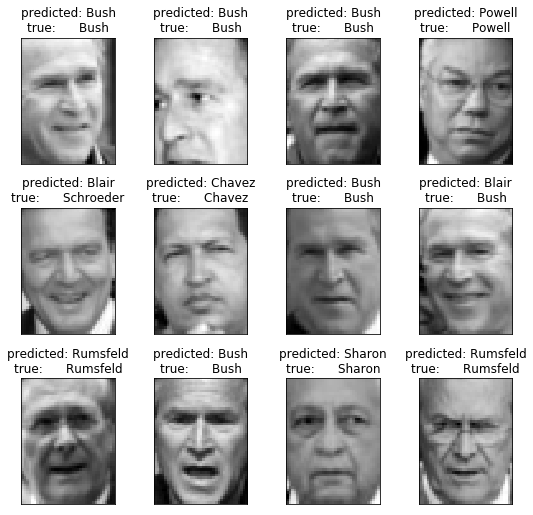

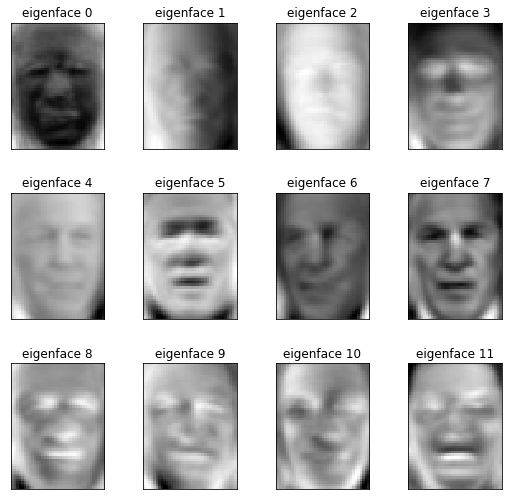

In [ ]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())


# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)